# Lab 09: Clustering


In [9]:
# Install yellowbrick if you don't already have it or are in colab
#!pip install yellowbrick

In [3]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

import matplotlib.cm as cm

import seaborn as sns
%matplotlib inline

In [4]:
# Load iris datset, set 'species' to be categorical variable containing
# class labels
iris = datasets.load_iris()
X = iris.data
y = iris.target
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                    columns= iris['feature_names'] + ['target'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.drop('target', axis='columns',inplace=True)

In [5]:
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa

# Exploring and Evaluating Clusters

## K-means

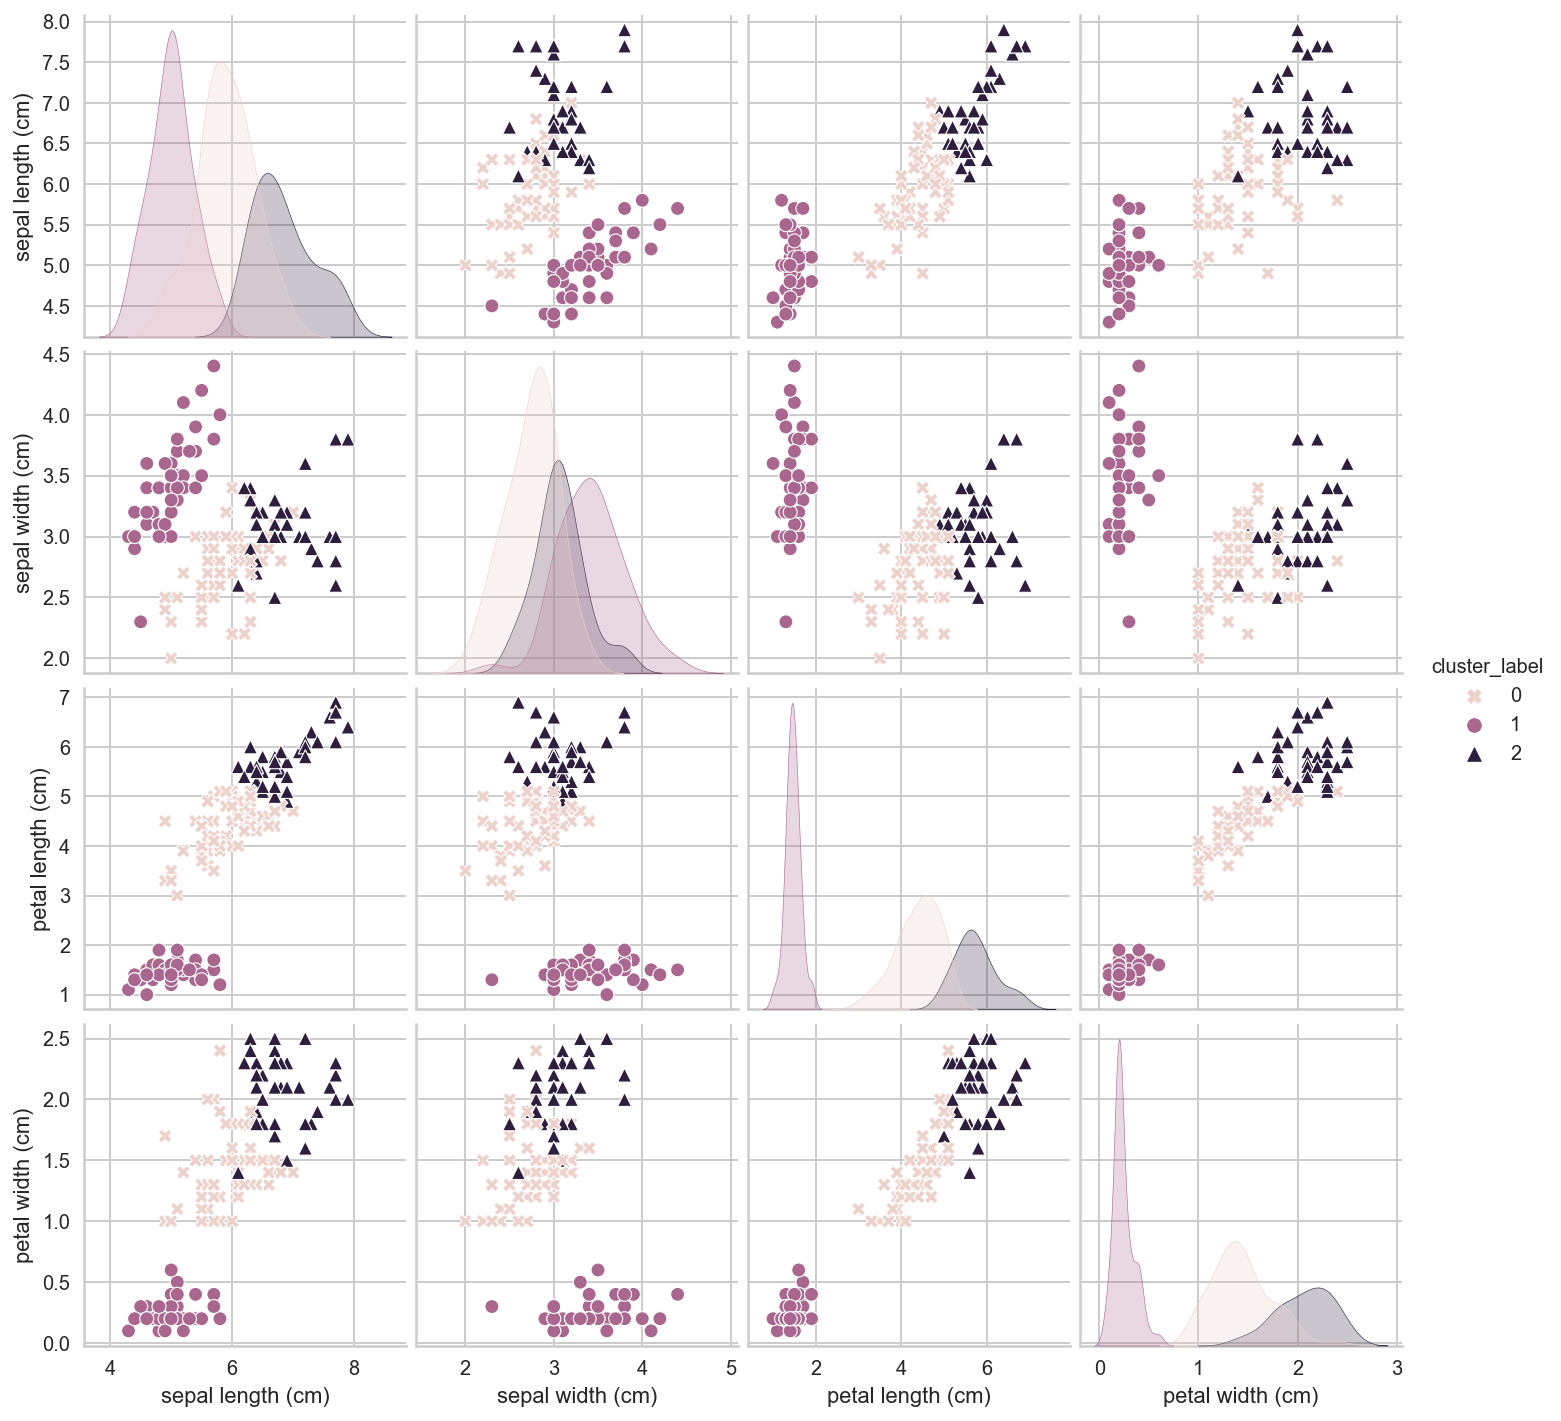

In [7]:
# Initializing the cluster algorithm
KClusterer = KMeans(n_clusters=3) # Name of operator and cluster number


# Fit the cluster and predict the label in one step. Calls any preprocessing step plus model
df['cluster_label'] = KClusterer.fit_predict(X)

# Create a pairplot using seaborn
sns.pairplot(vars=iris['feature_names'], # Variable names   
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^'],      # Differentiate markers
             data=df                     # What data to use
            )

plt.show()

Now we'll use the elbow method to determine the optimal number of clusters. For this, we will use the package [yellowbrick](https://www.scikit-yb.org/en/latest/quickstart.html), which specializes in visualization of data science models (give it a read, it's pretty interesting!). In particular we will use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function. By default, it will give us the location of the elbow using the [kneed](https://github.com/arvkevi/kneed) algorithm. 

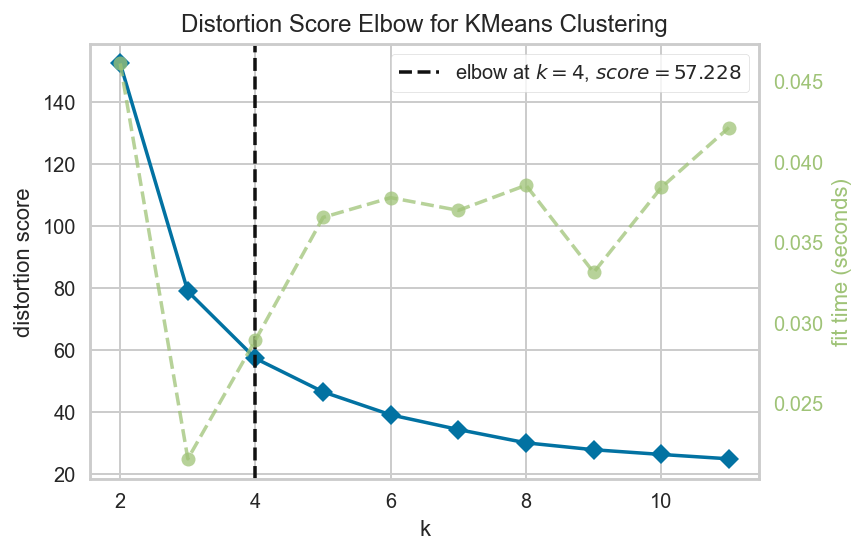

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Initialize the object
visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,12),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=True # Plot the timings to train?
                             )   

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The method suggests it's actually four cluster the optimal number. Let's test this theory.

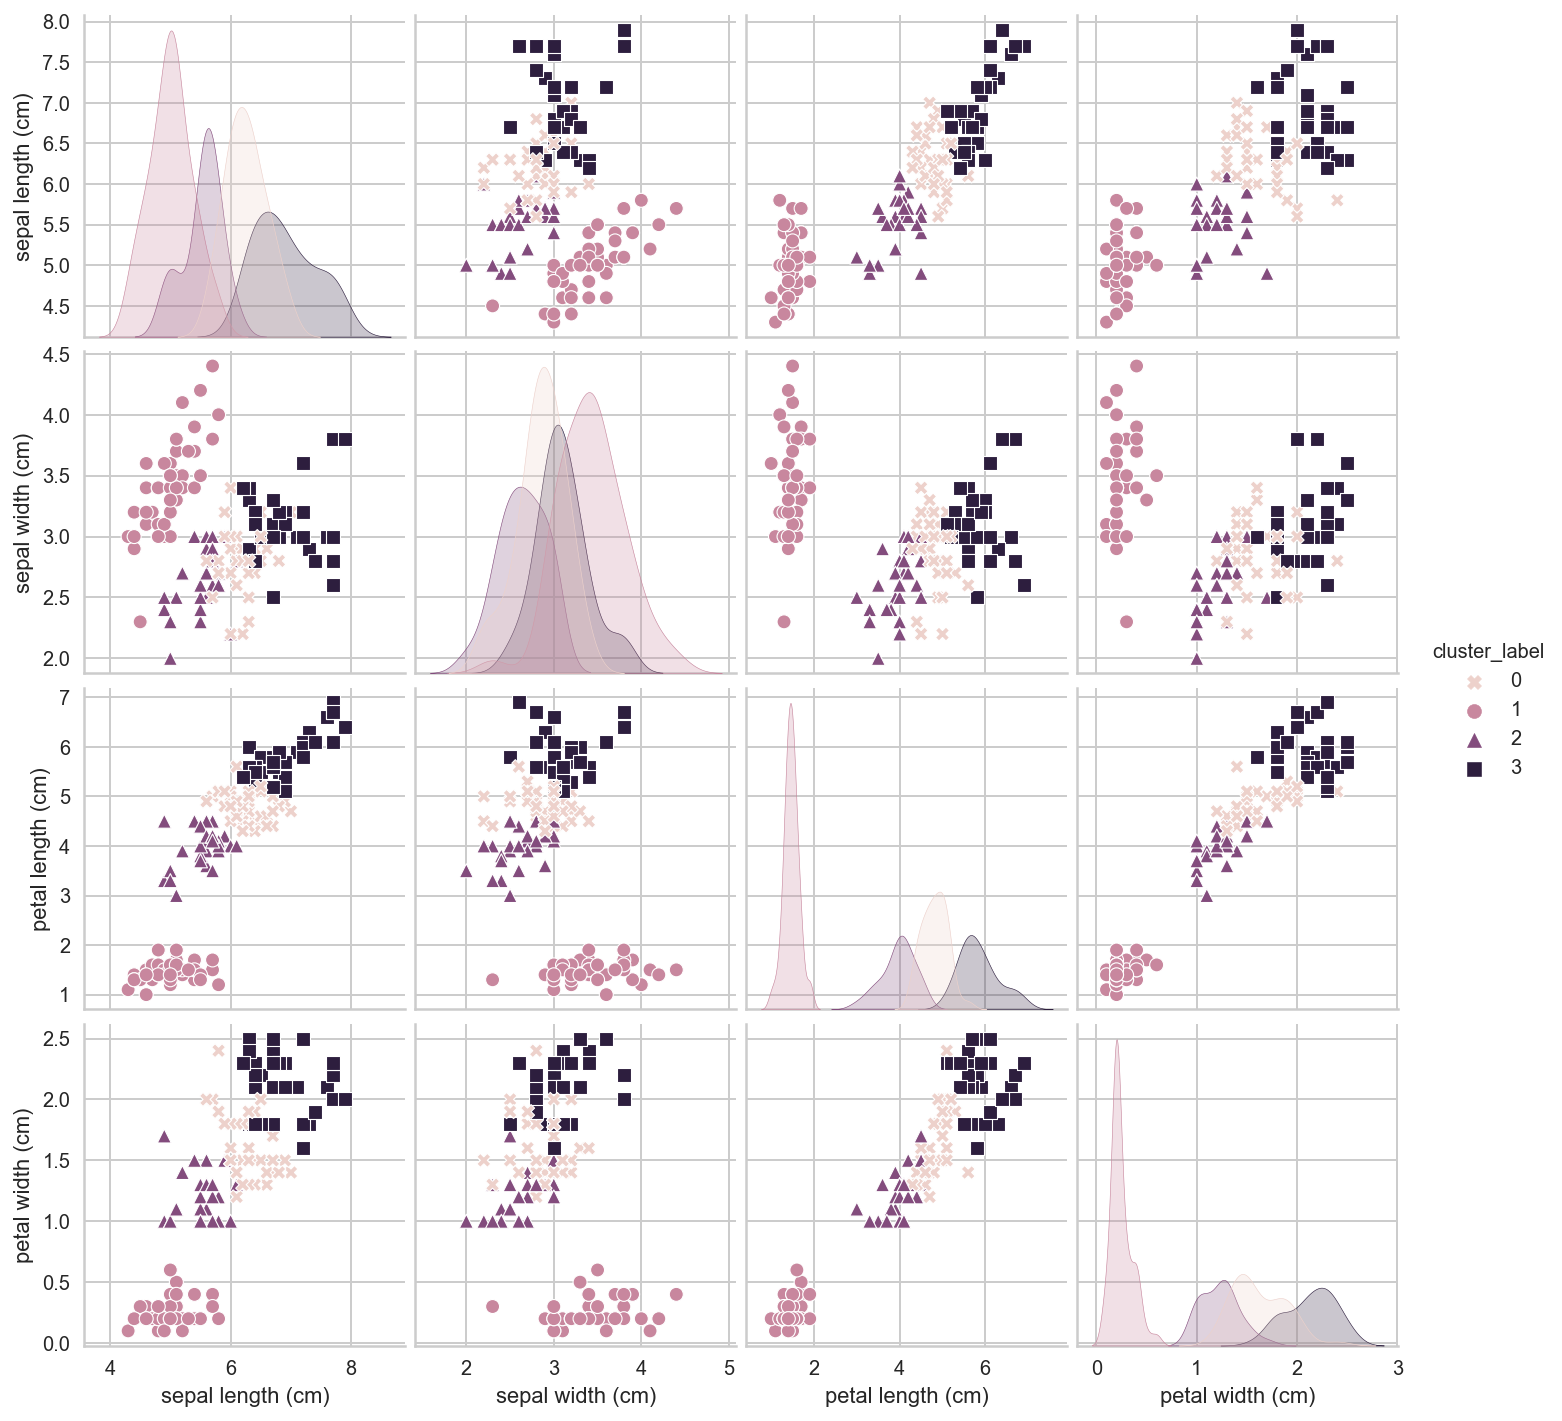

In [10]:
# Initializing the cluster algorithm
KClusterer = KMeans(n_clusters=4) # Name of operator and cluster number


# Fit the cluster and predict the label in one step. Calls any preprocessing step plus model
df['cluster_label'] = KClusterer.fit_predict(X)

# Create a pairplot using seaborn
sns.pairplot(vars=iris['feature_names'], # Variable names   
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^', 's'],      # Differentiate markers
             data=df                     # What data to use
            )

plt.show()

It does look better, no? This is a simple way to determine the number of clusters in your models!

## Agglomerative

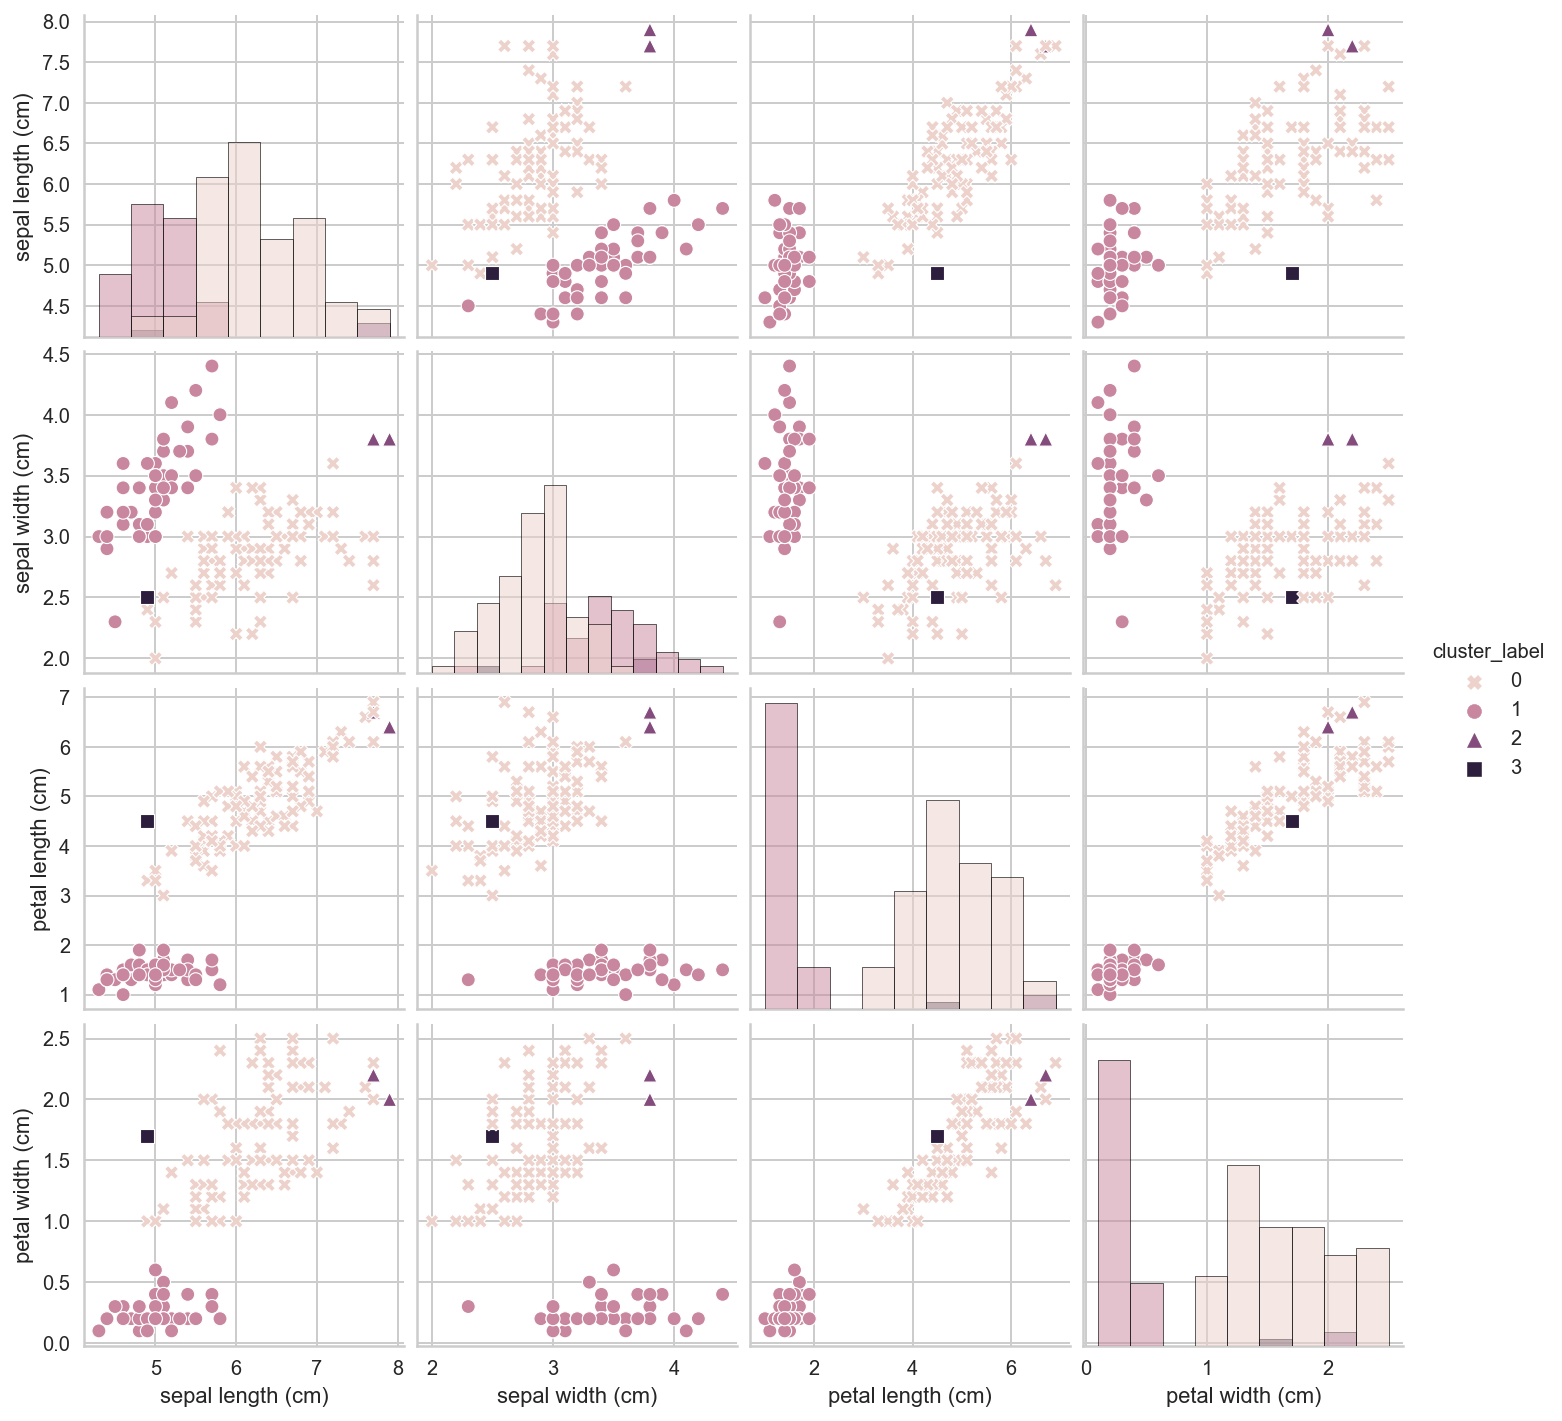

In [19]:
# Now a pipeline with the agglomerative cluster.
AgglomerativeIris = AgglomerativeClustering(n_clusters=4,         # Number of clusters
                                            affinity='euclidean', # Type of distance. Depends on your data and you can create your own!
                                            linkage="single"      # Type of linkage.  
                                            )

df['cluster_label'] = AgglomerativeIris.fit_predict(X)

sns.pairplot(vars=iris['feature_names'], 
             hue='cluster_label',
             markers=['X','o','^','s'],
             data=df,
             diag_kind='hist'            # What plot to use for diagonal. kde causes issues in single linkage due to too few points
            )
plt.show()

Four does not seem to be the optimal number of clusters for this model! You could use the elbow method, but you need to implement it on your own. The alternative is the silhouette method (see below).

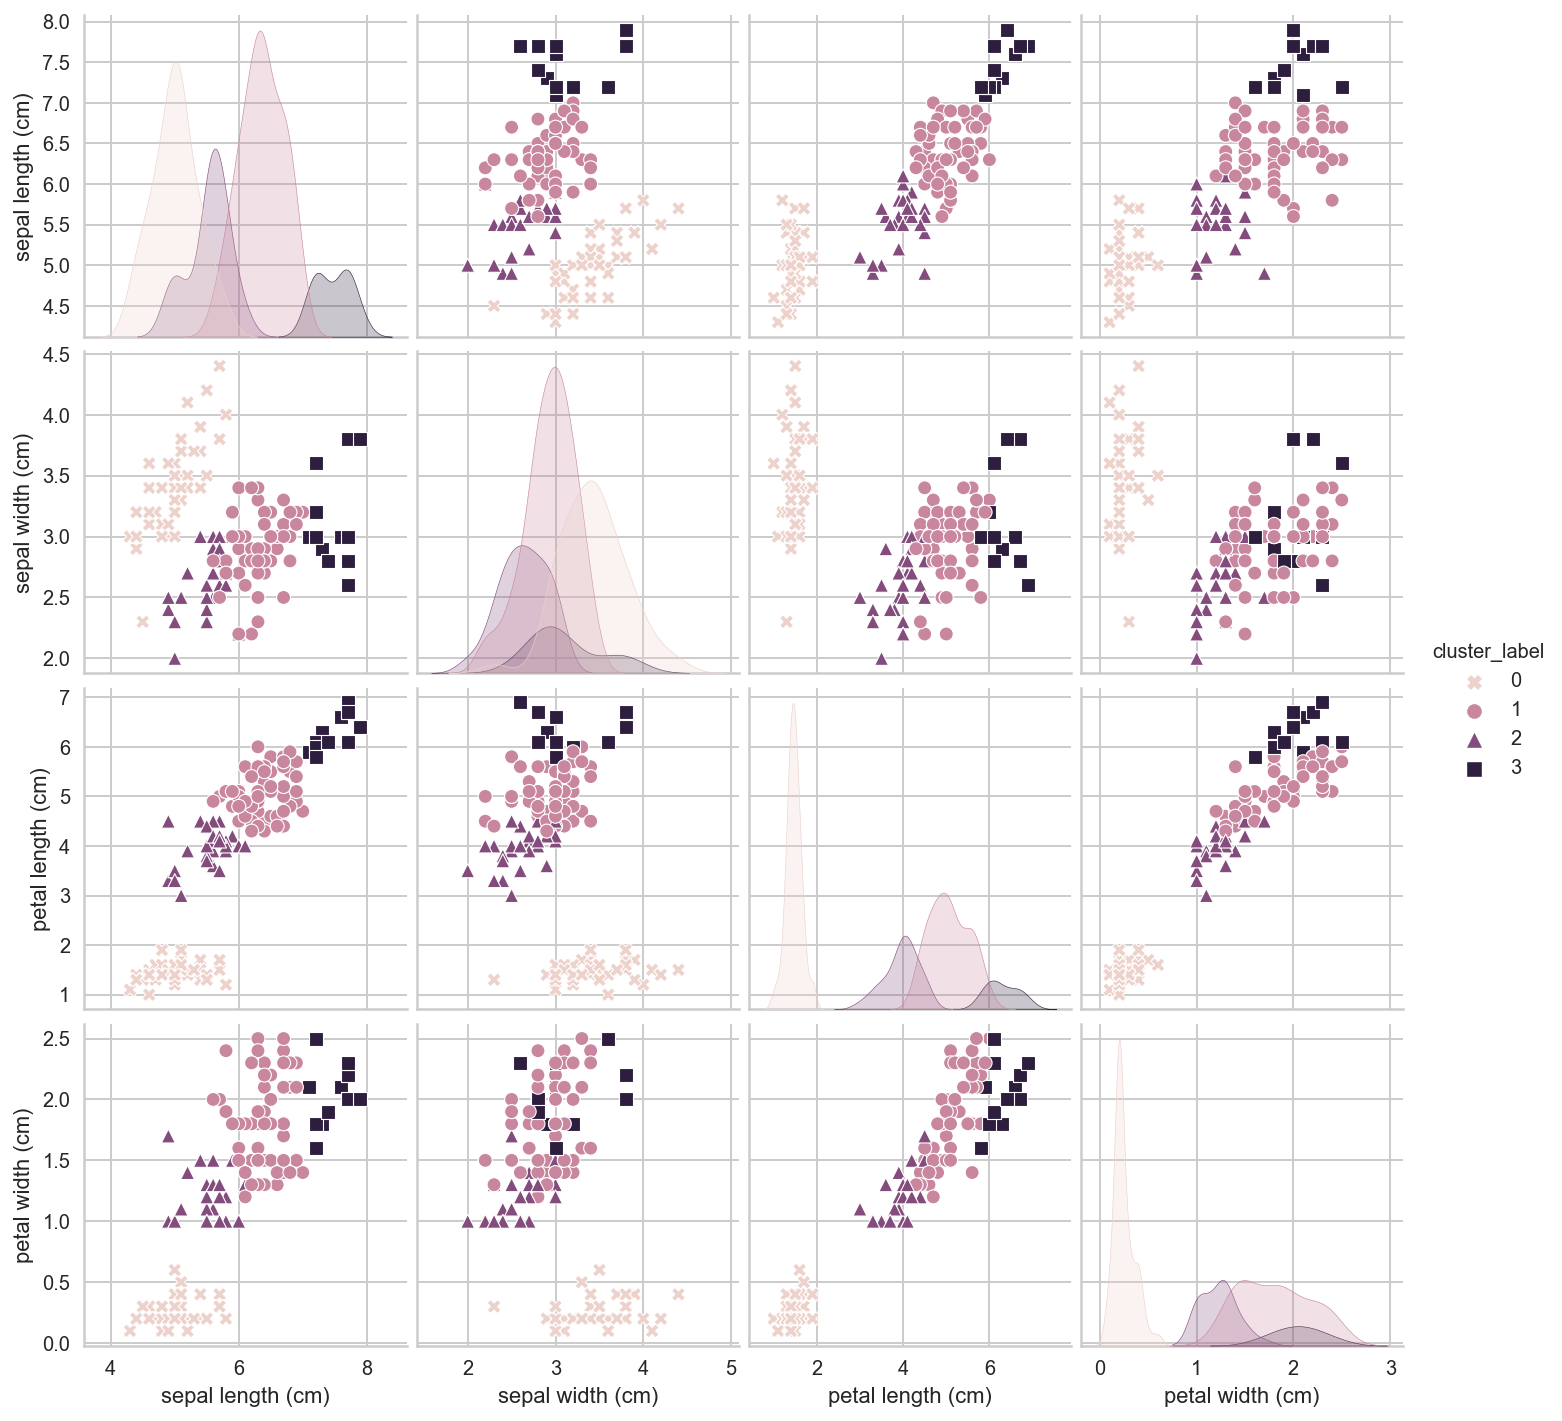

In [15]:
# Now a pipeline with the agglomerative cluster. 
cl_pipe = Pipeline([
    ('aggcl',AgglomerativeClustering(n_clusters=4,         # Number of clusters
                                     affinity='euclidean', # Type of distance. Depends on your data and you can create your own!
                                     linkage="complete"      # Type of linkage.  
                                    )
    )
])

df['cluster_label'] = cl_pipe.fit_predict(X)

sns.pairplot(vars=iris['feature_names'], 
             hue='cluster_label',
             markers=['X','o','^','s'],
             data=df,
             diag_kind='kde'            # What plot to use for diagonal.
            )
plt.show()

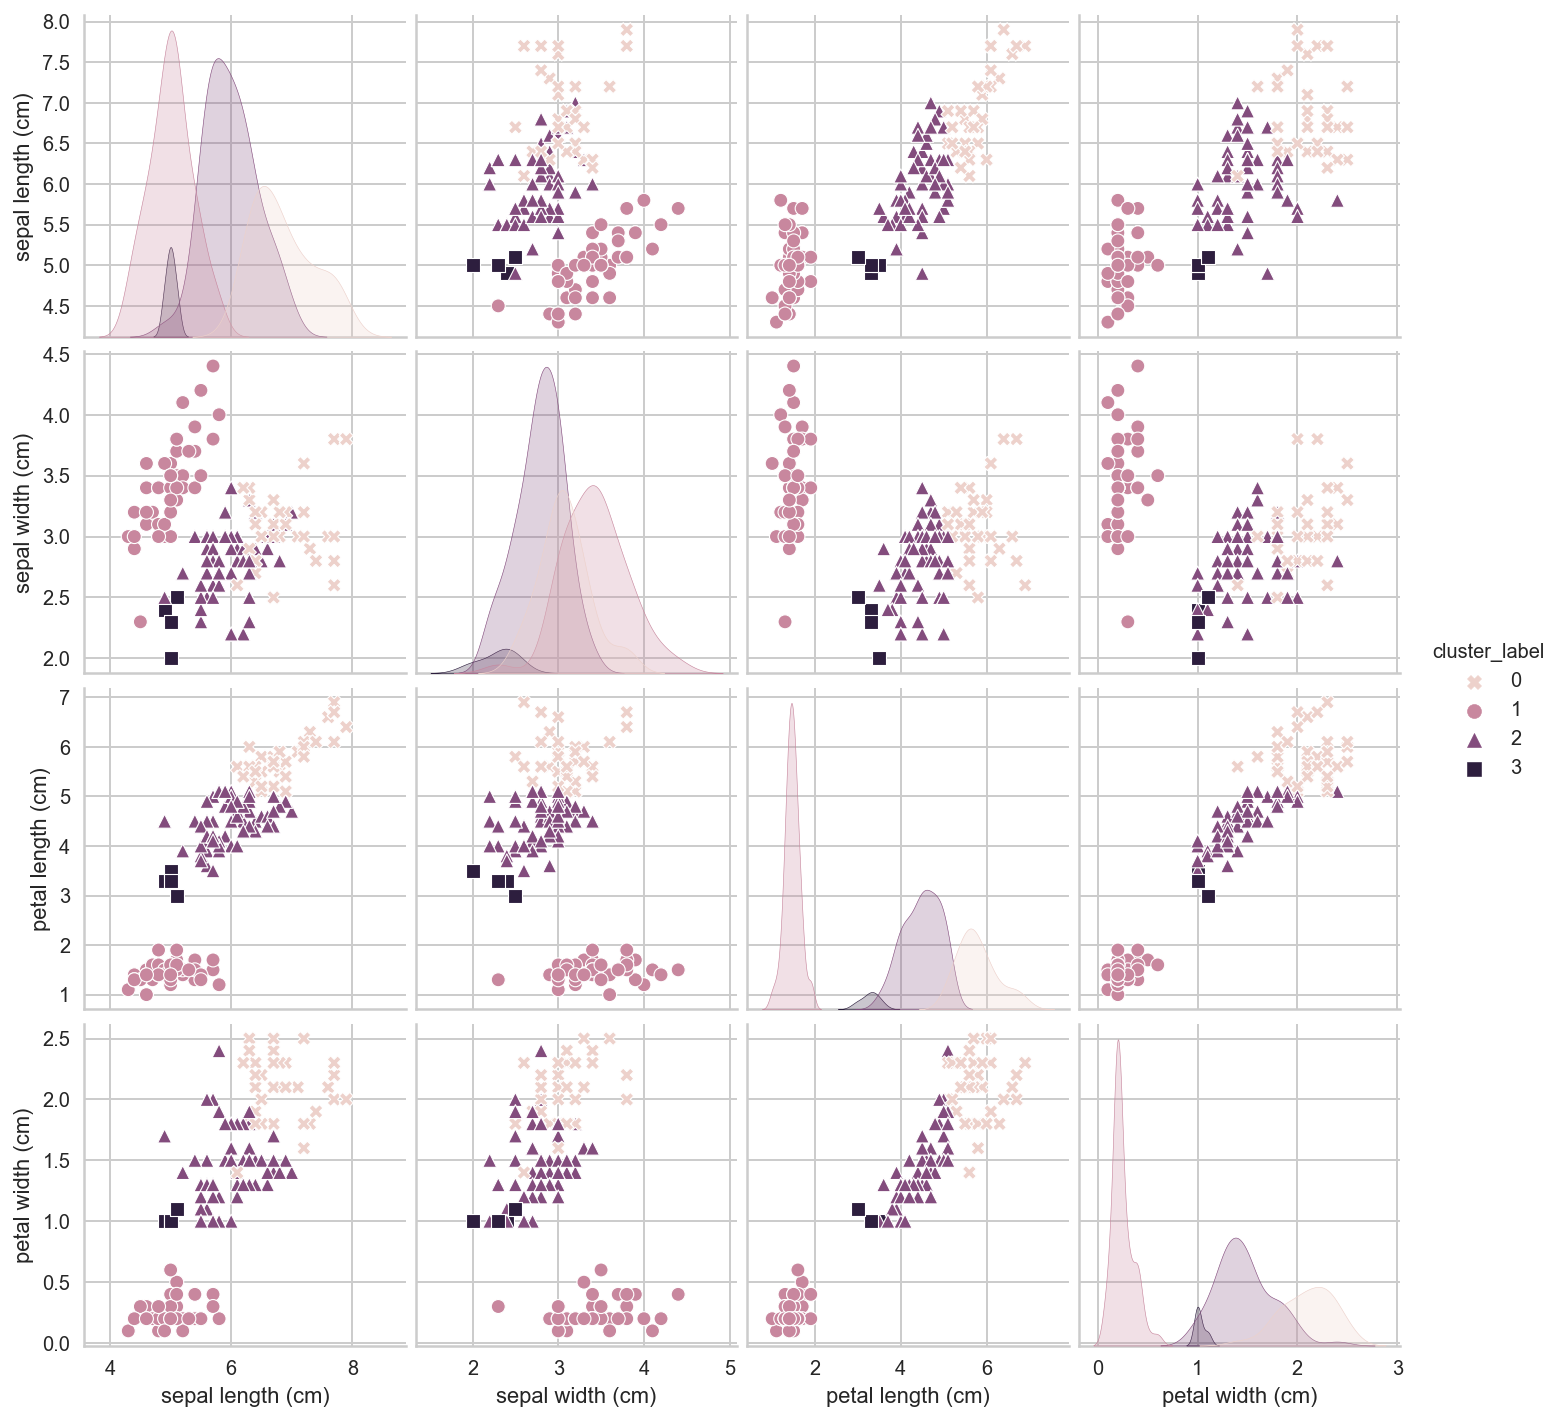

In [22]:
# Now a pipeline with the agglomerative cluster. 
cl_pipe = Pipeline([
    ('aggcl',AgglomerativeClustering(n_clusters=4,         # Number of clusters
                                     affinity='euclidean', # Type of distance. Depends on your data and you can create your own!
                                     linkage="average"      # Type of linkage. Options 
                                    )
    )
])

df['cluster_label'] = cl_pipe.fit_predict(X)

sns.pairplot(vars=iris['feature_names'], 
             hue='cluster_label',
             markers=['X','o','^','s'],
             data=df,
             diag_kind='kde'            # What plot to use for diagonal.
            )
plt.show()

## Scaling

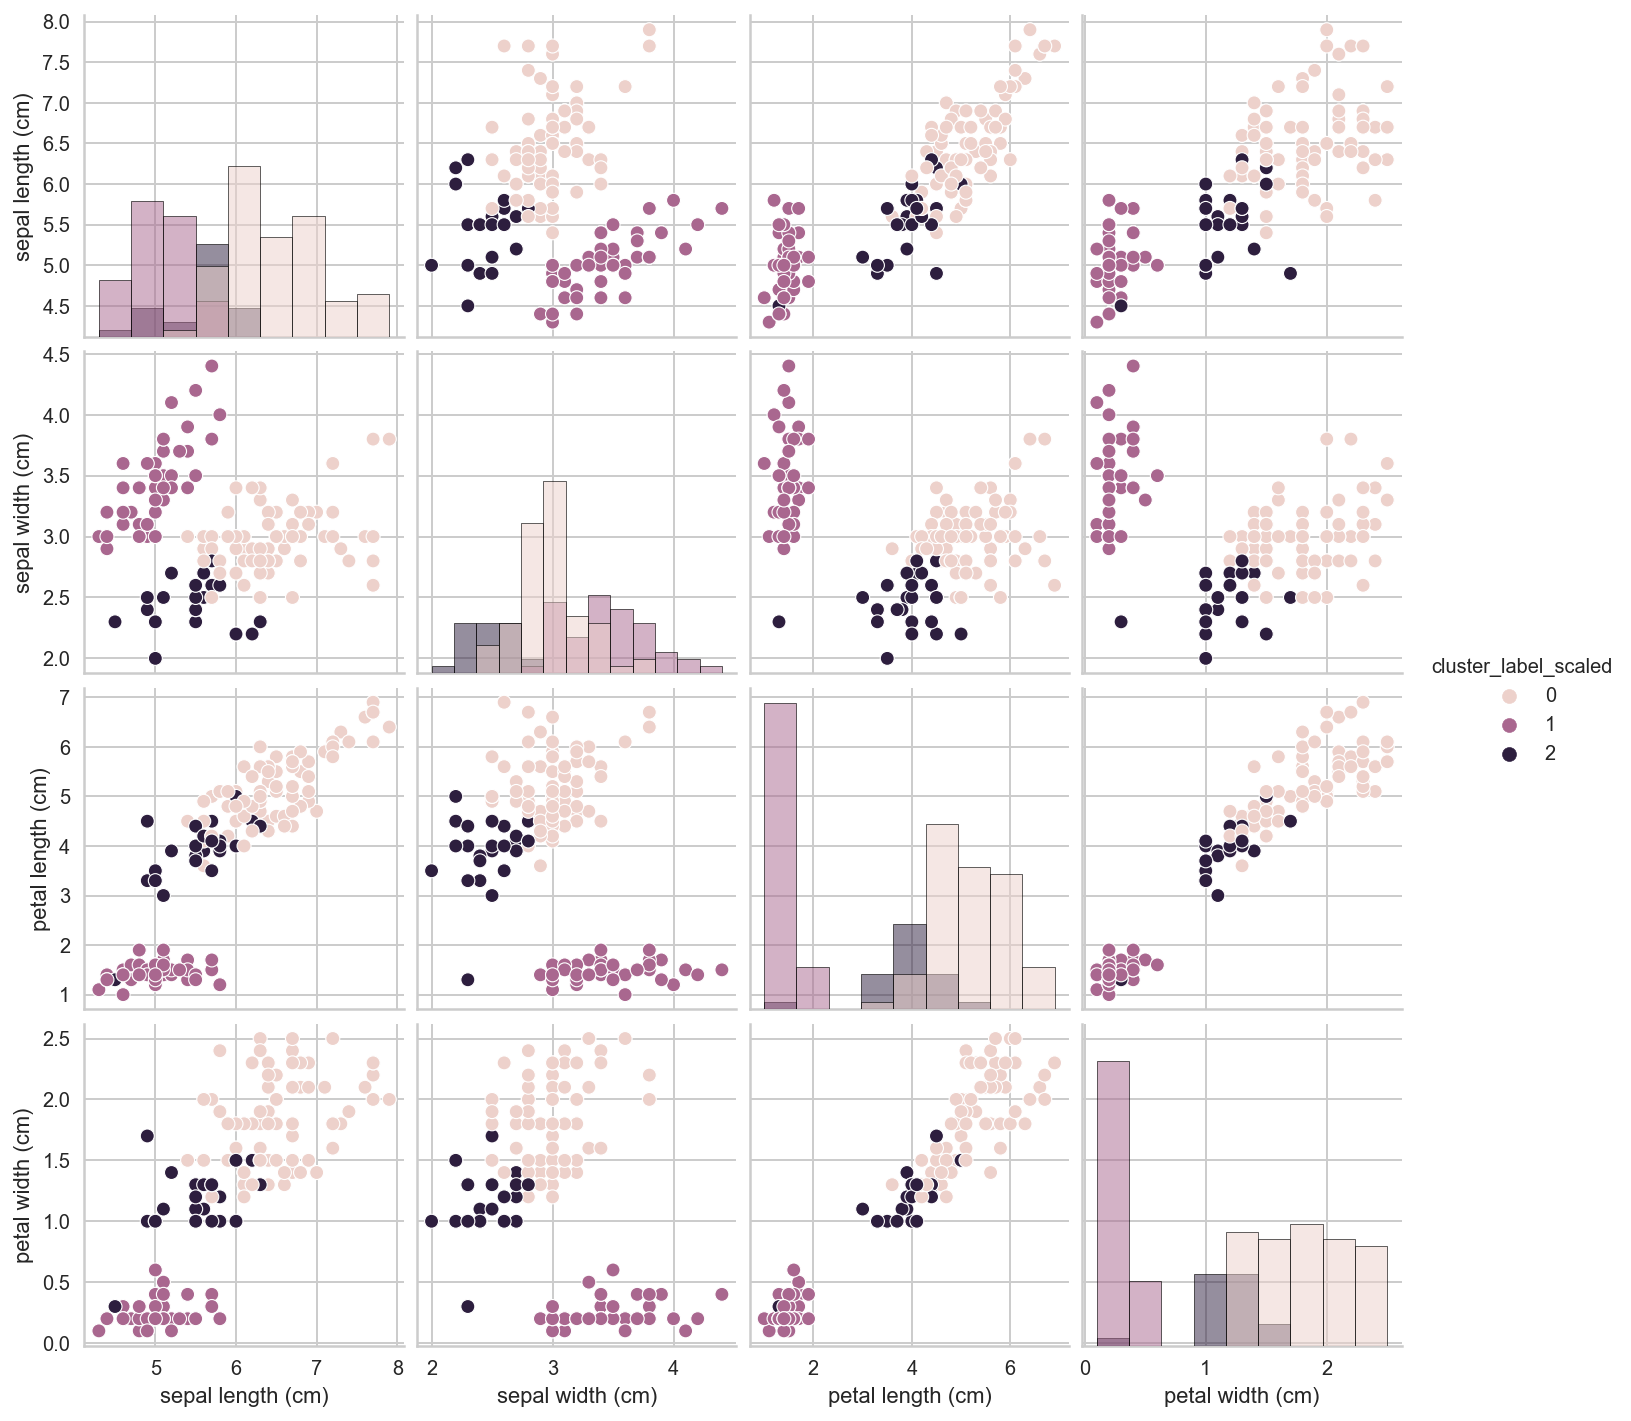

In [23]:
# Now we create a proper pipeline with scaling and a model
cl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=3, linkage="complete"))
])

# Again we fit and predict
df['cluster_label_scaled'] = cl_pipe.fit_predict(X)

# And we plot
sns.pairplot(vars=iris['feature_names'],
             hue='cluster_label_scaled',
             data=df,
             diag_kind='hist')
plt.show()

# Some synthetic data

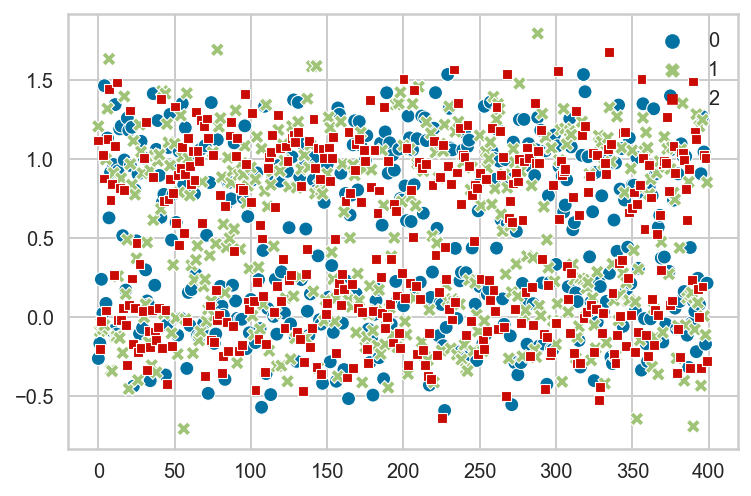

In [24]:
centers = [(0,0,0),(0,0,1),(0,1,0),(0,1,1),
           (1,0,0),(1,0,1),(1,1,0),(1,1,1)]
X, y = datasets.make_blobs(n_samples=400, centers=centers, 
           cluster_std=0.25, shuffle=True, random_state=0)

synth_df = pd.DataFrame(X)
sns.scatterplot(data=X)
plt.show()

The silhouette score is equal to 0.399


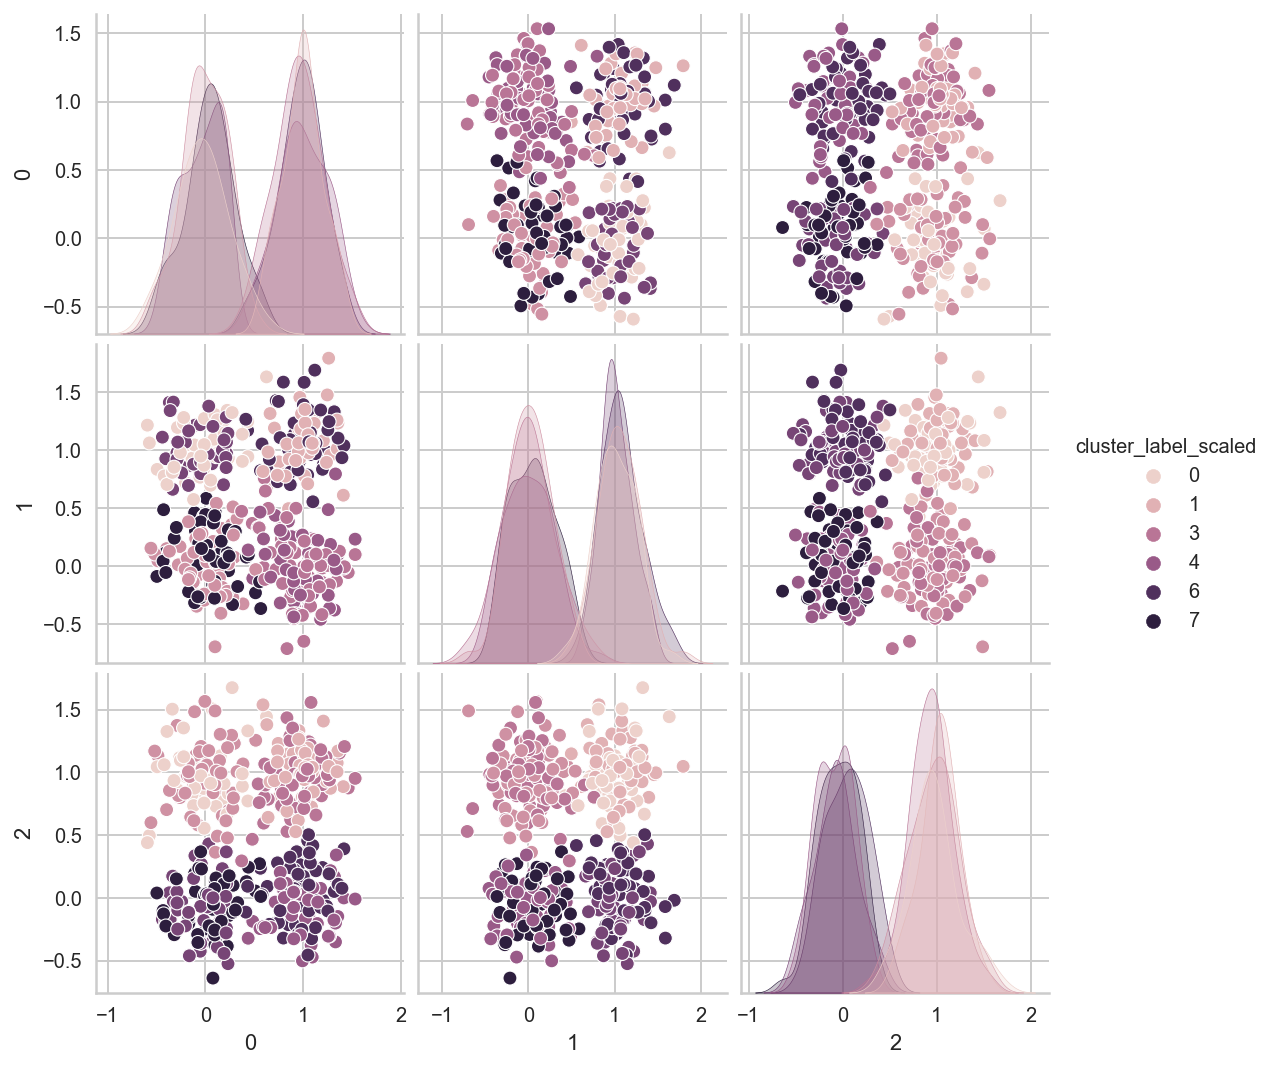

In [25]:
acl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=8, linkage="average"))
])

synth_df['cluster_label_scaled'] = acl_pipe.fit_predict(X)

print('The silhouette score is equal to %.3f' % silhouette_score(X, synth_df['cluster_label_scaled']))

sns.pairplot(hue='cluster_label_scaled', vars=[0,1,2], data=synth_df)
plt.show()

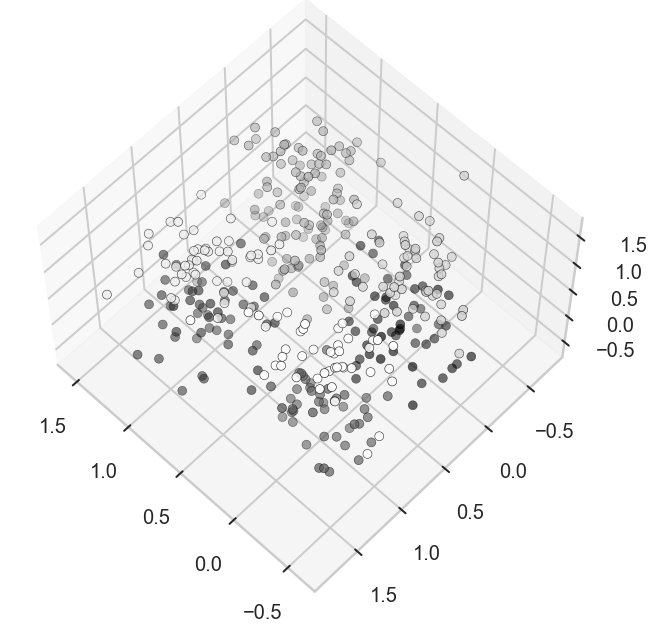

In [26]:
fig = plt.figure(figsize=(4, 4))
ax = Axes3D(fig, elev=60, azim=134, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(synth_df.iloc[:, 0], synth_df.iloc[:, 1], synth_df.iloc[:, 2],
           c=synth_df['cluster_label_scaled'], edgecolor='k')
plt.show()

# Silhouette Plot Example

In [27]:
# Make some complex data
X, y = datasets.make_moons(n_samples=400, random_state=0)

synth_df = pd.DataFrame(X)

The silhouette score for an Agglomerative Cluster is 0.334


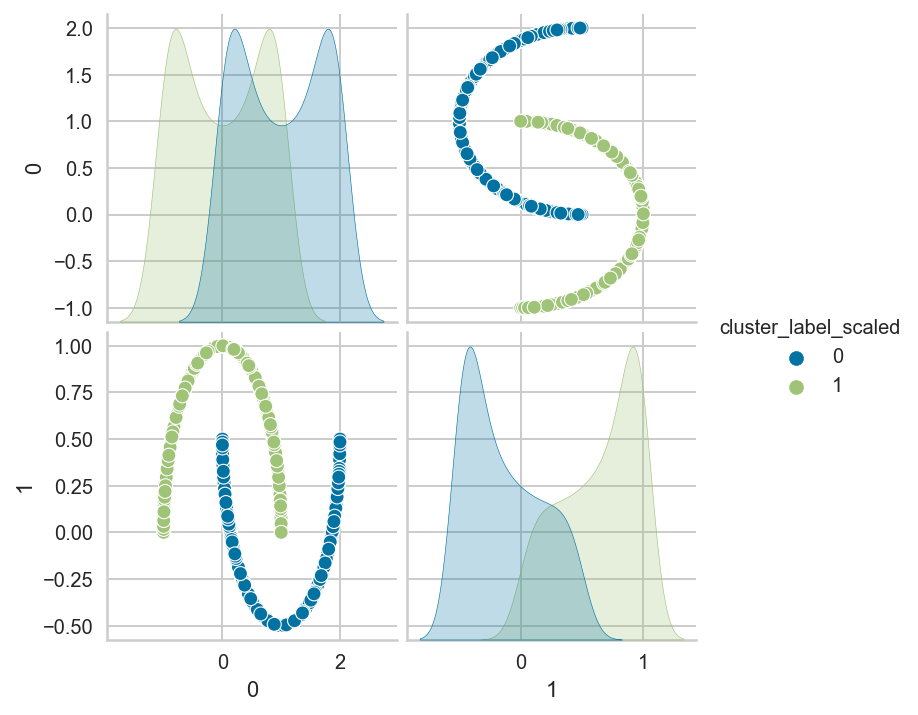

In [28]:
# Create a pipeline
acl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=2, linkage="single"))
])

# Fit it
synth_df['cluster_label_scaled'] = acl_pipe.fit_predict(X)

# Calculate the silhouette score
agg_sil_avg = silhouette_score(X, synth_df['cluster_label_scaled'])
print('The silhouette score for an Agglomerative Cluster is %.3f' % agg_sil_avg)

# plot the output
sns.pairplot(hue='cluster_label_scaled', vars=[0,1], data=synth_df)
plt.show()

The silhouette score for K-means is 0.473


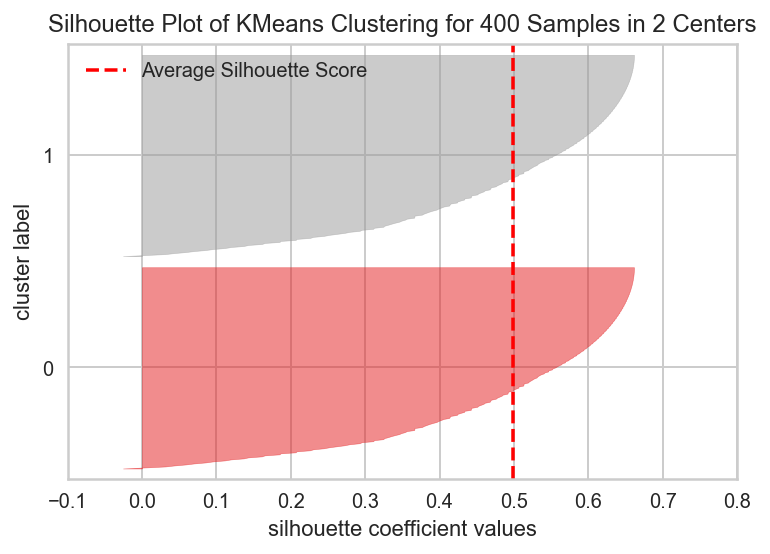

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 400 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
# Repeat, but now using k-means
kmeans_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', KMeans(n_clusters=2))
])

kmeans_pipe.fit(X)
synth_df['cluster_label_scaled'] = kmeans_pipe.predict(X)

kmeans_sil_avg = silhouette_score(X, synth_df['cluster_label_scaled'])
print('The silhouette score for K-means is %.3f' % kmeans_sil_avg)

# We can plot a silhouette plot for k-means using yellowbricks
visualizer = SilhouetteVisualizer(kmeans_pipe[1]) # Get the kmeans model
visualizer.fit(kmeans_pipe[0].transform(X)) # Pass the scaled data
visualizer.show() # show the plot

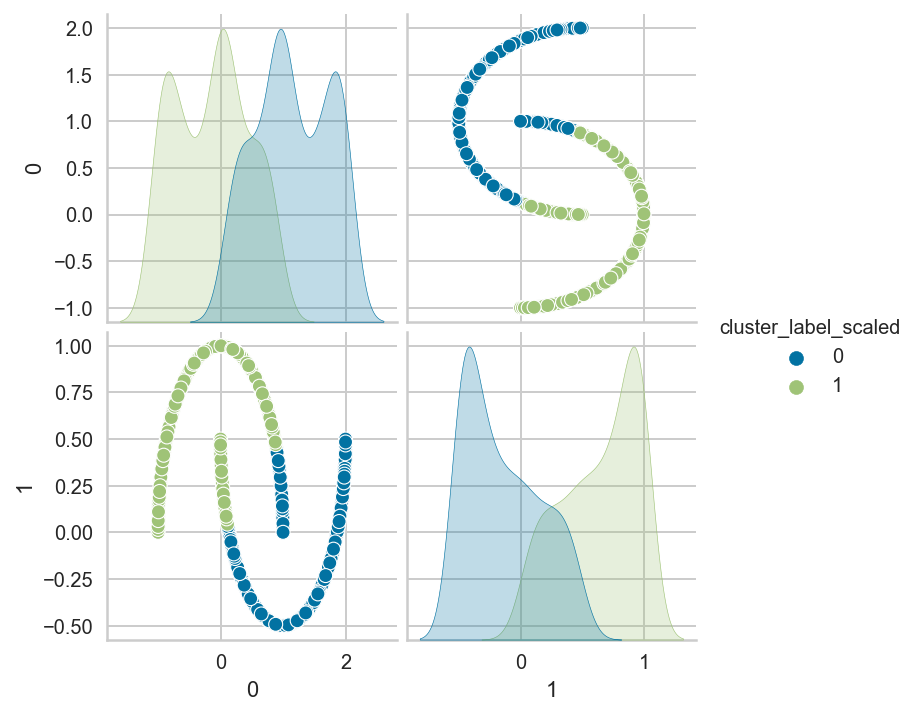

In [39]:
# We also plot the pairplot
sns.pairplot(hue='cluster_label_scaled', vars=[0,1], data=synth_df)
plt.show()

As yellowbricks does not (yet) allow for agglomerative clustering models, we need to manually calculate the silhouette scores. The following code does that and compares both.

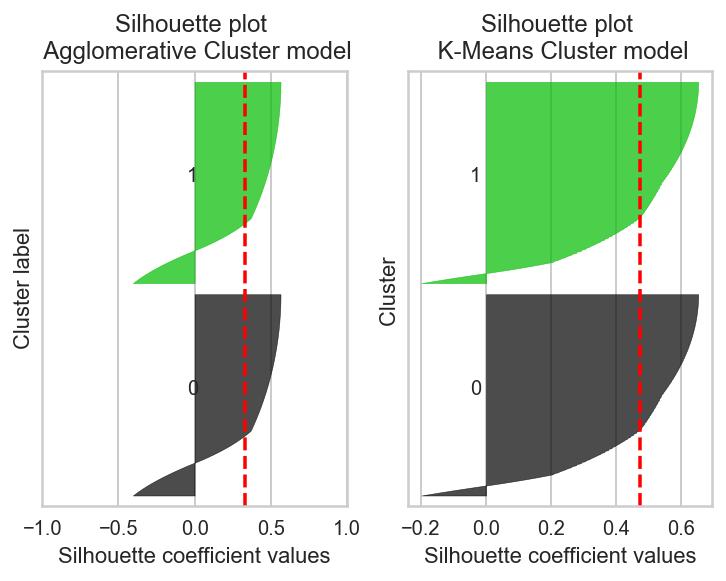

In [41]:
# Create a full silhoutte plot for the models

# Initialize the plot. Two plots, side-by-side, stores in ax1 and ax2.
fig, (ax1, ax2) = plt.subplots(1, 2)
n_clusters = 2

# Set limits. Score can go between -1, 1 but they sometimes can be trimmed.
ax1.set_xlim([-1, 1])
ax1.set_xlim([-1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax2.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
agg_cluster_labels = acl_pipe.fit_predict(X)
kmeans_cluster_labels = kmeans_pipe.fit_predict(X)


# Compute the silhouette scores for each sample
sample_silhouette_values_agg = silhouette_samples(X, agg_cluster_labels)
sample_silhouette_values_kmeans = silhouette_samples(X, kmeans_cluster_labels)

y_lower = 10

# Iterate over the clusters - Agglomerative
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values_agg[agg_cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot \n Agglomerative Cluster model")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=agg_sil_avg, color="red", linestyle="--")

ax1.set_yticks([])

# Iterate over the clusters - K-means
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values_kmeans[kmeans_cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_title("Silhouette plot \n K-Means Cluster model")
ax2.set_xlabel("Silhouette coefficient values")
ax2.set_ylabel("Cluster ")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=kmeans_sil_avg, color="red", linestyle="--")

ax2.set_yticks([])  

plt.show()